**Name: Hoda Shoghi**

**Contact: hoda.shoghi@gmail.com**

**Date: 27 July 2023**

### Project Title: 

# Predicting Restaurant Ratings: A Data-Driven Approach

### Step1: Cleaning and EDA:
As 1st step I  will perform basic EDA and data cleaning to get familiarize with Yelp's business dataset.

#### Dataset
The Yelp dataset offers a wealth of information about businesses across several cities. This project focuses specifically on restaurant businesses. The dataset includes attributes such as business ID, name, location, review count, categories, and star ratings.

| COLUMN NAME  | DESCRIPTION                                                    | DATA TYPE |
|--------------|----------------------------------------------------------------|-----------|
| business_id  | Unique identifier for the business                             | string    |
| name         | Name of the business                                           | string    |
| address      | Address where the business is located                          | string    |
| city         | City where the business is located                             | string    |
| state        | State where the business is located                            | string    |
| postal_code  | postal_code where the business is located                      | string    |
| latitude     | Geographical latitude of the business                          | float64   |
| longitude    | Geographical longitude of the business                         | float64   |
| stars        | Star rating of the business                                    | float64   |
| review_count |  Number of reviews the business has received                   | int64     |
| is_open      | 0 is closed and 1 is open                                      | int64     |
| attributes   | Dict-different attribute like payment method,  , etc | string  |
| categories   | Categories the business falls under                            | string    |
| hours        | Dict-Hours of operation                                        | string    |


#### Data Notes :
1- Yelp's dataset covers various types of businesses. For this project, I focus on businesses categorized as "Restaurants".

2- The `categories` column can contain multiple categories for a single business. For example, a restaurant can be categorized as both 'Italian' and 'Pizza'.

3- Yelp users rate businesses on a scale of 1 to 5 stars. This serves as our target variable, which we aim to predict with our model.

4- `attribute` Column contains dictionary of different attributes and their values

5- There are some nested dictionaries inside `attributes` Column like `Ambience` or `Business Parking`

#### My goal :

My goal is to build a predictive model that can accurately predict a restaurant's star rating by leveraging the vast amount of information in the dataset. This model can provide prospective Steakholders with insights into how certain factors might influence their new establishment's ratings.



### Step1-2  Basic Data Wrangling
1- What is the shape of the dataframe?

2- What kind of data is stored in each column? How are they distributed?

3- Are there any columns that contain duplicate information? If so, remove the redundant columns.

4- Are there any null values in the dataframe? If so, handle them appropriately.


First lets open the **jason** datasaet which is downloaded from Yelp website

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df_b = pd.read_json('data/yelp_business.json', lines=True)


1-What's the shape opf data frame?

In [9]:
df_b.shape

(150346, 14)

2-What kind of data is stored in each column?

Lets have a look at the head of the datafram:

In [ ]:
df_b.head()

## " is_open" Column

In [ ]:
df_b['is_open'].value_counts()

The DataFrame contains a column 'is_open', which carries binary values - 0 signifies a closed business, while 1 indicates an open one. for now we keep all the businesses.

In [ ]:
# 1 = open, 0 = closed
df_b['is_open'].value_counts()

In [ ]:
# Define the threshold for a low rating
low_rating_threshold = 2.5  # or any other value you define as "low"

# Filter the dataframe for rows with a rating less than or equal to the threshold
low_rating_df = df_b[df_b['stars'] <= low_rating_threshold]

# Calculate the proportion of these restaurants that are closed
closed_proportion = (low_rating_df['is_open'] == 0).mean()

print(f"Proportion of restaurants with a rating ≤ {low_rating_threshold} that are closed: {closed_proportion:.2%}")


## " state" Column

In [ ]:
df_b['state'].value_counts()

Examining the value counts reveals that our dataset does not include information for every state in the US. However, to avoid reducing the number of data points, we have decided to retain all of them.

lets have a look at columns again: 

In [ ]:
df_b.info()

Some of these features are not going to be useful to us. In particular,because we want to focus on features that have the most impact on the restaurant rating so we can remove the following:

In [ ]:
df_b.drop(df_b.columns[[0,1,2,4,5,6,7,13]],axis=1,inplace=True)

In [ ]:
df_b.info()

### Missing Values?

Before examining the contents of the `categories` and `attributes` columns, I observed that they contain some missing values, and I will remove these null values now before proceeding with my analysis.

In [ ]:
df_b['categories'].isna().sum()

In [ ]:
df_b['attributes'].isna().sum()

We must remove the missing values, as they are detrimental to our models.

In [ ]:
df_b.dropna(subset=['categories','attributes'], inplace=True)

In [ ]:
df_b.info()

## " categories" Column


When analyzing the `categories` column in the DataFrame, df_b. I noticed that the categories is messy and contains a wide array of businesses, not just restaurants.

In [ ]:
df_b['categories']

### Standardize the categories


Next, I wanted to standardize the text in the categories column to prevent any discrepancies due to capitalization or leading/trailing spaces. So, I converted all the category names to lower case using the str.lower() method and removed any unnecessary spaces at the beginning or end of these category names with the str.strip() method.

In [ ]:
df_b['categories'] = df_b['categories'].str.lower().str.strip()
df_b.reset_index(drop=True)

df_b.shape

In [ ]:
df_b['categories'].value_counts().head(10)


 Subsequently, to focus on the businesses that are related to restaurants, I utilized the str.contains() method to filter out such rows. 

In [ ]:
df_b = df_b[df_b['categories'].str.contains('restaurants')]
df_b.reset_index(drop=True)
df_b.shape

In [ ]:
df_b.head()

### Category Flattening

The code below first splits the 'categories' column in the df_b DataFrame by commas and assigns the resulting lists to a new DataFrame, df_exploded. Then, it uses the 'explode' method to transform each element of the lists into a separate row, effectively flattening the 'categories' column.

In [ ]:
df_exploded = df_b.assign(categories = df_b.categories.str.split(', ')).explode('categories')
df_b.reset_index(drop=True)


Lets prints the value counts of the unique categories, displaying all the rows without any truncation.


In [ ]:
with pd.option_context('display.max_rows', None):
    print(df_exploded['categories'].value_counts())


 We need to apply one-hot encoding to these categories, but before doing that, it's advisable to first identify and handle the categories that have very low value counts

**Reducing Dimensionality:** In this datasets, categorical features have many unique categories, some of which occur very infrequently. If we one-hot encode these categories directly, we may end up with a large number of binary features, each representing a unique category. This can significantly increase the dimensionality of the data. By first selecting and possibly combining or removing categories with very low value counts, we can reduce the number of binary features that will be created, keeping the dimensionality more manageable.

**Handling Noise:** Categories with very low value counts might represent noise or anomalies in the data. These rare categories might not provide meaningful information for predictive modeling and could even harm the model's performance by introducing randomness or bias. By identifying and handling these categories separately, we can make the one-hot encoding more robust to such noise.

**Improving Model Generalization:** Rare categories that appear only a few times in the training data may lead to overfitting, where the model learns to memorize these specific instances rather than generalizing from them. By handling these low-count categories separately (for example, by combining them into an "other" category), we can help the model to generalize better from the data.

Let's create a list of categories with very low counts, so we can remove them later on.

In [ ]:
# Finding the categories that have counts less than 100 in the 'categories' column of the df_exploded DataFrame
categories_with_low_counts = df_exploded['categories'].value_counts()

# Storing these low-count categories in the 'low_count_categories' list 
low_count_categories = categories_with_low_counts[categories_with_low_counts < 100].index.tolist()
#and printing the list
print(low_count_categories)



## One-Hot Encoding Categories

In the preprocessing stage of our data, we have multiple categories represented as comma-separated strings. These need to be transformed into a format that can be understood by machine learning algorithms. The following steps outline this transformation process:

1. **Lowercasing and Stripping Whitespace**: We first convert the 'categories' column to lowercase and remove any extra whitespace to ensure uniformity.

2. **Splitting Categories**: The 'categories' are split based on commas into a list of categories for each record.

3. **Resetting the Index**: This is done to ensure alignment between the original DataFrame and the subsequent one we'll create with one-hot encoding.

4. **One-Hot Encoding**: We utilize the `MultiLabelBinarizer` from scikit-learn to transform the categories into a binary matrix. This creates a new column for each unique category, with a 1 or 0 indicating its presence.

5. **Creating a DataFrame**: The binary matrix is converted into a DataFrame, with column names corresponding to the unique categories.

6. **Concatenating with the Original DataFrame**: The one-hot encoded DataFrame is concatenated with the original DataFrame, adding the new binary columns.

7. **Dropping the Original 'categories' Column**: Optionally, the original 'categories' column is dropped as it has now been represented in the one-hot encoded format.

By the end of this process, our original DataFrame `df_b` contains binary columns representing the presence or absence of each category, ready for further analysis or modeling.


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Splitting the categories on commas and stripping any extra whitespace
df_b['categories'] = df_b['categories'].str.lower().str.strip().apply(lambda x: x.split(', '))

# Resetting the index to ensure alignment
df_b.reset_index(drop=True, inplace=True)


In [ ]:

# Using MultiLabelBinarizer to one-hot encode the categories
mlb = MultiLabelBinarizer()
categories_encoded = mlb.fit_transform(df_b['categories'])

# Convert the one-hot encoded categories into a DataFrame
categories_df = pd.DataFrame(categories_encoded, columns=mlb.classes_)

# Concatenate this DataFrame with the original one
df_b = pd.concat([df_b, categories_df], axis=1)




In [ ]:
df_b.shape

## Removing Low-Count Categories

After one-hot encoding the categories, we might end up with a high dimensionality if there are many unique categories. Some of these categories might only appear a few times in the dataset. Such low-count categories can sometimes introduce noise or complexity without adding much informative value.




In [ ]:
for col in low_count_categories:
    if col in df_b.columns:
        df_b.drop(columns=col, inplace=True)
df_b = df_b.reset_index(drop=True)


In [ ]:
# Drop the original 'categories' column (if desired)
df_b = df_b.drop(columns=['categories'])

By the end of this process, our DataFrame `df_b` has been streamlined, with all the columns corresponding to the identified low-count categories removed. This can help in reducing dimensionality, improving computational efficiency, and potentially enhancing the performance of subsequent modeling.

In [ ]:
df_b.shape

## Identifying Highly Correlated Variable Pairs

Correlation between variables can often reveal interesting relationships, but high correlation can sometimes be a concern in modeling as it may lead to multicollinearity. This code snippet is focused on identifying pairs of variables in the DataFrame `df_b` that have a correlation greater than 0.50.

Here's what the code does:


1. **Calculating the Correlation Matrix**: Using the `corr` method, we compute the correlation matrix for the DataFrame `df_b`. This matrix contains the Pearson correlation coefficients between all pairs of variables.

2. **Initializing a List for Highly Correlated Pairs**: We create an empty list called `highly_correlated_pairs` to store the variable pairs that meet our correlation threshold.

3. **Iterating Through the Matrix**: We use nested loops to iterate through the correlation matrix, examining each pair of variables.

4. **Checking for High Correlation**: Inside the loops, we check if the correlation is above 0.50 and ensure that we are not on the diagonal (where correlation is always 1). 

5. **Avoiding Duplicate Pairs**: Since the correlation matrix is symmetric, we check that we haven't already stored the pair in the reverse order (e.g., `(j,i)` instead of `(i,j)`).

6. **Storing and Printing the Pairs**: If a pair meets the criteria, we append it to our list and later print all such pairs.

By the end of this process, we have a list of variable pairs in the DataFrame that are highly correlated, which can be insightful for feature selection or for further investigation into the relationships between these variables.


In [ ]:

correlation_matrix = df_b.corr()

# Get pairs of variables with correlation > 0.50
highly_correlated_pairs = []

for i, row in enumerate(correlation_matrix.index):
    for j, col in enumerate(correlation_matrix.columns):
        # Check for correlation above 0.50 and ensure we're not looking at the diagonal
        if correlation_matrix.iloc[i, j] > 0.50 and i != j:
            # Since the matrix is symmetric, let's only store one of (i,j) or (j,i)
            if (col, row) not in highly_correlated_pairs:
                highly_correlated_pairs.append((row, col))

# Print the results
for pair in highly_correlated_pairs:
    print(f"Variables {pair[0]} and {pair[1]} have a correlation > 0.50")



## Handling Highly Correlated Variables

In our analysis, we identified several pairs of variables that have a correlation greater than 0.50. Some of these pairs are intuitively related, such as:

- **Arts & Entertainment and Music Venues**
- **Automotive and Convenience Stores, Gas Stations**
- **Bars and Nightlife**
- **Beer and Wine & Spirits**
- **Breweries and Brewpubs**
- **Caterers and Event Planning & Services**
- **Ethnic Food and Specialty Food**
- **Hawaiian and Poke**
- **Hotels and Hotels & Travel**
- **Japanese and Sushi Bars**

These high correlations indicate that these variables are likely conveying similar information, and it might be beneficial to combine or reduce them to avoid potential multicollinearity in our models.

### Combining Correlated Variables

We took the following approach to combine and simplify these correlated variables:

1. **Creating Combined Columns**: For each pair or group of highly correlated variables, we created a new combined column that represents the logical OR of the variables. For example, `American_cuisine` combines 'american (traditional)' and 'american (new)'.

2. **Dropping the Specified Columns**: We used the `drop` method to remove the specified irrelevent columns from the DataFrame, reducing redundancy.

By handling these correlated variables, we simplified our dataset while retaining the essential information. This process can help in reducing dimensionality and improving the interpretability and performance of subsequent modeling.


In [ ]:
import numpy as np

# Combining columns as described
df_b['American_cuisine'] = np.logical_or(df_b['american (traditional)'], df_b['american (new)'])
df_b['Bars_nightlife'] = df_b['bars'] | df_b['nightlife']
df_b['Beer_wine_spirits'] = df_b['beer'] | df_b['wine & spirits']
df_b['Caterers_event_planning'] = df_b['caterers'] | df_b['event planning & services']
df_b['Specialty_food'] = df_b['specialty food'] | df_b['specialty food']
df_b['Japanese'] = df_b['japanese'] | df_b['sushi bars']
df_b['BrewPub'] = df_b['breweries'] | df_b['brewpubs']
df_b['Hawaiian_poke'] = df_b['hawaiian'] | df_b['poke']
df_b['Mexican_tacos'] = df_b['mexican'] | df_b['tacos']


# List of original columns to drop
columns_to_drop = [
    'arts & entertainment',
    'music venues',
    'convenience stores',
    'gas stations',
    'hotels & travel',
    'american (traditional)',
    'american (new)',
    'bars',
    'nightlife',
    'beer',
    'wine & spirits',
    'caterers',
    'event planning & services',
    'specialty food',
    'japanese',
    'sushi bars',
    'breweries',
    'brewpubs',
    'hawaiian',
    'poke',
    'mexican',
    'tacos',
    'restaurants',
    'food'
]

# Drop the specified columns
df_b = df_b.drop(columns=columns_to_drop)



In [ ]:
df_b.shape

# Attribute Column

In [ ]:
df_b.reset_index(drop=True, inplace=True)


This features contains a list for each restaurant with various descriptions. Take for example the list from the first , 2nd and 3rd restaurants in the data frame.

In [ ]:
for i in range(0,2):
    print(df_b['attributes'][i],'\n')

Observing the `attributes` columns, we find that they contain dictionaries. Therefore, it would be beneficial to unpack or "explode" these dictionaries into separate columns for better analysis and understanding of the data.

Let's first look at what's inside the attributes column. We need to see what keys are there and decide if these keys give us useful information for our project. Should we keep them as new columns?

In [ ]:
keys = set()

for attr in df_b['attributes']:
    if isinstance(attr, dict):  # check if the entry is a dictionary
        keys.update(attr.keys())
print(keys)



We can observe that the restaurant data contains various attributes. However, it is noticeable that not all restaurants have a complete set of attributes. Our objective is to find the restaurant with the most extensive list of attributes among them.

## Finding the Restaurant with the Most Attributes

In our restaurant data, we have various attributes describing each establishment. However, we've observed that not all restaurants have a complete set of attributes. Our goal in this code segment is to identify the restaurant that has the most extensive list of attributes among all the entries in the dataset.

Here's how we achieve this:

1. **Initialize Variables**: We start with `length = 0` to keep track of the longest attribute list found so far and `loc = None` to store the index location of this restaurant.

2. **Iterate Through the DataFrame**: We loop through the DataFrame `df_b`, specifically the 'attributes' column, and check the length of each entry.

3. **Check for a New Maximum Length**: If we find an attribute list longer than our current maximum, we update both `length` and `loc` to reflect this new maximum.

4. **Handle None Values**: In some cases, the 'attributes' value might be `None`, leading to a TypeError when trying to find its length. We handle this exception by simply passing over these cases.

5. **Store the Result**: After iterating through the entire DataFrame, the restaurant's attributes at the location `loc` are stored in `result_attributes`.

6. **Final Result**: The final result, stored in `result_attributes`, contains the dictionary of attributes for the restaurant with the most extensive list.

By following this procedure, we've pinpointed the specific restaurant with the most comprehensive attribute set, providing valuable insights into what might be a particularly well-documented or multifaceted establishment. This information could be utilized further in analysis or feature engineering.


In [ ]:
length = 0
loc = None  # Use None to represent no valid location found

for i in range(len(df_b)):
    try:
        if len(df_b['attributes'][i]) > length:
            length = len(df_b['attributes'][i])
            loc = i
    except TypeError:
        # Handle the case where the value in 'attributes' is None
        pass
result_attributes = df_b['attributes'][loc]
result_attributes

## Tallying the Occurrence of Specific Restaurant Attributes

In our restaurant dataset, there is a diverse range of attributes that can describe different characteristics of an establishment. These might include whether the restaurant takes reservations, provides Wi-Fi, allows outdoor seating, etc. To understand how often these attributes are used across the dataset, we have implemented the following procedure:

1. **List of Target Attributes**: We have defined a list `attributes` that includes the specific restaurant characteristics we are interested in analyzing. This list encompasses various aspects like 'Music,' 'WheelchairAccessible,' 'BusinessAcceptsBitcoin,' and so on.

2. **Initialize Tally Counter**: A counter `tally` is initialized with zeros and has the same length as our target attributes. It will be used to store the count of each attribute's occurrence in the dataset.

3. **Iterate Through the DataFrame**: We loop through the DataFrame `df_b`, specifically the 'attributes' column, and check each entry.

4. **Check for None Values**: If an entry in the 'attributes' column is not `None`, we extract the attribute names (`ats`) from the entry by splitting each attribute string at the colon.

5. **Update Tally**: For each target attribute, if it is found in the extracted attribute names (`ats`), we increment the corresponding count in the tally.

6. **Print Results**: Finally, we print the attribute names and their counts, providing an insight into how often each of these specific characteristics appears in the dataset.

This analysis allows us to understand the prevalence of different attributes across the restaurants in our dataset. Such insights could be beneficial in exploring trends, preferences, or common practices within the industry. It also aids in feature selection or engineering by identifying the attributes that might be more relevant or significant for further analysis or modeling.


In [ ]:
attributes = ['RestaurantsReservations', 'Music', 'BYOBCorkage', 'BusinessAcceptsCreditCards', 'WiFi', 'RestaurantsTakeOut', 'RestaurantsPriceRange2', 'WheelchairAccessible', 'AcceptsInsurance', 'Open24Hours', 'BikeParking', 'Ambience', 'DriveThru', 'BusinessParking', 'RestaurantsGoodForGroups', 'BYOB', 'CoatCheck', 'HappyHour', 'Caters', 'GoodForKids', 'GoodForMeal', 'Alcohol', 'Corkage', 'RestaurantsTableService', 'DogsAllowed', 'RestaurantsAttire', 'RestaurantsDelivery', 'NoiseLevel', 'ByAppointmentOnly', 'BestNights', 'DietaryRestrictions', 'Smoking', 'AgesAllowed', 'GoodForDancing', 'RestaurantsCounterService', 'HasTV', 'OutdoorSeating', 'BusinessAcceptsBitcoin']

In [ ]:

tally = [0] * len(attributes)

for i in range(len(df_b)):
    if df_b['attributes'][i] is not None:
        ats = [attr.split(':', 1)[0] for attr in df_b['attributes'][i]]
        
        for j in range(len(attributes)):
            if attributes[j] in ats:
                tally[j] += 1

# Print attribute names and their counts
for i in range(len(attributes)):
    print(f"{attributes[i]}: {tally[i]}")


## Visualizing the Occurrence of Restaurant Attributes

To better understand and communicate the occurrence of different restaurant attributes across our dataset, we're visualizing the data in a sorted bar chart. Here's a step-by-step explanation of what the code does:

1. **Sort Indices Based on Tally**: Using the `sorted` function, the code first gets the indices that would sort the `tally` list in descending order. These indices will allow us to reorder both the `attributes` and the `tally` lists to align with the sorted counts.

2. **Rearrange Lists Based on Sorted Indices**: The `sorted_attributes` and `sorted_tally` lists are created by rearranging the `attributes` and `tally` lists based on the sorted indices. This ensures that the attributes are ordered by their corresponding counts.

3. **Plot the Results**: With the sorted data, we create a bar plot using the Matplotlib library. The x-axis represents the attributes, and the y-axis represents the counts of those attributes in the dataset. 


This visualization provides a clear and comprehensive view of how frequently different attributes occur across the restaurant dataset. By sorting the attributes by their counts, we can immediately identify the most common and rare attributes, which can be vital for subsequent analysis and decision-making.


In [ ]:

# Get the indices that would sort the 'tally' list in descending order
sorted_indices = sorted(range(len(tally)), key=lambda k: tally[k], reverse=True)

# Rearrange the 'attributes' and 'tally' lists based on the sorted indices
sorted_attributes = [attributes[i] for i in sorted_indices]
sorted_tally = [tally[i] for i in sorted_indices]

# Plot the sorted results
plt.figure(figsize=(12, 6))
plt.bar(sorted_attributes, sorted_tally)

plt.xticks(rotation=90)
plt.xlabel('Attribute')
plt.ylabel('Count')
plt.title('Attribute Occurrence Count in Restaurants (Sorted)')
plt.tight_layout()
plt.show()


{'ByAppointmentOnly', 'WiFi', 'OutdoorSeating', 'GoodForKids', 'RestaurantsDelivery',  'RestaurantsReservations', 'Caters', 'Ambience', 'RestaurantsGoodForGroups', 'RestaurantsTakeOut', 'Alcohol', 'RestaurantsAttire', 'HappyHour', 'WheelchairAccessible', 'RestaurantsPriceRange2', 'BikeParking', 'BusinessParking', 'NoiseLevel'}


we decided to  remove the attributes with leass than 1000 occurence and calculate how many restaurant reviews contain all of the other attributes.
we also removed some of the attributes that are not important and useful to the analyse like 'has TV','BusinessAcceptsCreditCards'& etc..

Attributes column contains dictionary and 3 nested dictionary. To proceed, we will use the ast library to unpack all dictionaries.

## Extracting Key Attributes from the Dataset

Our dataset contains a wide array of attributes for restaurants, which are stored as strings representing dictionaries within the `'attributes'` column. However, we are interested in a specific subset of these attributes. The code snippet performs the following actions to focus on these selected attributes:

1. **Convert Strings to Dictionaries**: The `ast.literal_eval` function is used to convert the strings in the `'attributes'` column to dictionaries. This is done using the `apply` method along with a lambda function that checks whether each value is a string before applying the conversion. If a value is not a string (for example, if it is `None`), it is left unchanged.

2. **Define Key Attributes**: A list called `keys_to_keep` is defined, containing the specific attribute keys we are interested in. These include attributes such as `'WiFi'`, `'OutdoorSeating'`, `'GoodForKids'`, and so on.

3. **Create New Columns for Key Attributes**: For each key in the `keys_to_keep` list, a new column is created in the DataFrame. The value for each restaurant in these new columns is obtained from the corresponding dictionary in the `'attributes'` column, using the key. If the key is not found in the dictionary, or if the value is not a dictionary (such as when it's `None`), a `NaN` value is assigned.

By extracting these specific attributes and placing them in separate columns, the DataFrame becomes more accessible and ready for further analysis, focusing only on the aspects of the data that are most relevant to our study. This process enhances readability and efficiency in subsequent steps.


In [ ]:
import ast

# Convert the strings into dictionaries for 'attributes' column
df_b['attributes'] = df_b['attributes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

keys_to_keep = ['WiFi', 'OutdoorSeating', 'GoodForKids', 'RestaurantsDelivery', 'RestaurantsReservations', 'Caters', 'Ambience', 'RestaurantsGoodForGroups', 'RestaurantsTakeOut', 'Alcohol', 'RestaurantsAttire', 'HappyHour', 'WheelchairAccessible', 'RestaurantsPriceRange2', 'BikeParking', 'BusinessParking', 'NoiseLevel']

# For each key, create a new column in the DataFrame
for key in keys_to_keep:
    df_b[key] = df_b['attributes'].apply(lambda x: x.get(key) if isinstance(x, dict) else np.nan)



In [ ]:
df_b.columns

# BusinessParking Column
is a nested dictionary which was inside `attributes` column

In [ ]:
df_b['BusinessParking'].value_counts().head(5)

In [ ]:
# Convert the strings into dictionaries for 'BusinessParking' column
df_b['BusinessParking'] = df_b['BusinessParking'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

P_keys = set()

# Iterate over each entry in the 'BusinessParking' column
for attr in df_b['BusinessParking']:
    if isinstance(attr, dict):  # check if the entry is a dictionary
        P_keys.update(attr.keys())

print(P_keys)

lets explode it to new columns: 

In [ ]:

# For each key in 'BusinessParking', create a new column in the DataFrame
for key in P_keys:
    df_b[key] = df_b['BusinessParking'].apply(lambda x: x.get(key) if isinstance(x, dict) else np.nan)



In [ ]:
for i in P_keys :
    print(df_b[i].value_counts(),'\n')

In [ ]:
# Convert the set to a list
P_keys_list = list(P_keys)

# Convert parking columns to boolean type
df_b[P_keys_list] = df_b[P_keys_list].astype(bool)

# Initialize the 'ParkingAvailability' column
df_b['ParkingAvailability'] = False

# Iterate through the parking keys and update 'ParkingAvailability'
for col in P_keys_list:
    df_b['ParkingAvailability'] |= df_b[col]

# Print the value counts
print(df_b['ParkingAvailability'].value_counts(dropna=False))


In [ ]:
df_b.drop(columns=['validated', 'garage', 'valet', 'street', 'lot'], inplace=True)


# Ambience Column

In [ ]:
# Convert the strings into dictionaries for 'Ambience' column
df_b['Ambience'] = df_b['Ambience'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Initialize an empty set to store the keys in 'Ambience' column
Ambience_keys = set()

# Find all keys in 'Ambience' column
for entry in df_b['Ambience']:
    if isinstance(entry, dict):
        Ambience_keys.update(entry.keys())

# Now ambience_keys set contains all the unique keys present in the 'Ambience' column dictionaries
Ambience_keys

In [ ]:
# Convert the strings into dictionaries for 'Ambience' column
df_b['Ambience'] = df_b['Ambience'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

Ambience_keys = set()

# Find all keys in 'Ambience' column without using dropna
for entry in df_b['Ambience']:
    if isinstance(entry, dict):
        Ambience_keys.update(entry.keys())

# For each key in 'Ambience', create a new column in the DataFrame and fill NaN values with False
for key in Ambience_keys:
    df_b[key] = df_b['Ambience'].apply(lambda x: x.get(key, False) if isinstance(x, dict) else False)


In [ ]:
  df_b.columns

In [ ]:
for i in Ambience_keys:
    print(df_b[i].value_counts())

some of the ambiance columns have very few "True" values (e.g., touristy, upscale, romantic). To address this, I decided to combine them into broader categories, namely "Casual" and "Classy." This consolidation allows me to end up with three ambiance columns: "Casual," "Classy," and "Unknown."

To achieve this, I followed the following grouping:

**Casual: I combined the columns (divey, hipster, trendy) as they are related to a more relaxed and informal ambiance.**

**Classy: I combined the columns (intimate, romantic, upscale) as they are associated with a more sophisticated and upscale ambiance.**

By adopting this strategy, I can simplify the representation of ambiance factors while preserving their essential characteristics. The resulting ambiance columns provide a more balanced representation, allowing my logistic regression model to better capture the influence of ambiance on the target variable, which is the restaurant's rating (stars).

In [ ]:
for i in Ambience_keys:
    mapping = {
        False: 0,
        True: 1
    }
    df_b[i] = df_b[i].replace(mapping)
    df_b[i].fillna(0,inplace=True)

    # Sanity check: Display the counts of 0s and 1s in the current column
    print(df_b[i].value_counts())


In [ ]:
df_b.info()

Now that the attributes column is completely unpacked, we can drop both the attributes column and the BusinessParking column from the DataFrame.

In [ ]:
df_b.drop(columns=['attributes', 'BusinessParking','Ambience'], inplace=True)


In [ ]:
df_b.info()

Let's take a closer look at all the values in the columns that were exploded from the attributes column.

# WIFI Column

Based on the values in the `WiFi` column, we can convert it into a binary column, where '0' means no WiFi and '1' means WiFi is available. This simplifies the representation and makes it easier to understand the WiFi availability in the dataset.

In [ ]:
df_b['WiFi'].value_counts()

In [ ]:
import numpy as np

# Create a mapping to replace string values with corresponding integers
wifi_mapping = {
    "'free'": 1,
    "'no'": 0,
    "'paid'": 1,
    "u'free'": 1,
    "u'no'": 0,
    "None": np.nan,  # Now properly set to NaN
    "u'paid'": 1
}

# Replace the string values with corresponding integers
df_b['WiFi'] = df_b['WiFi'].replace(wifi_mapping)
df_b['WiFi'].fillna(0, inplace=True)
# Convert the 'WiFi' column to integers
df_b['WiFi'] = df_b['WiFi'].astype(float).astype('Int64')  # Use float and Int64 to support NaN

# Sanity check
print(df_b['WiFi'].value_counts())


In [ ]:
print(df_b['WiFi'].unique())


# OutdoorSeating

In [ ]:
df_b['OutdoorSeating'].value_counts()

In [ ]:
import numpy as np

# Create a mapping to replace string values with corresponding integers
outdoor_seating_mapping = {
    'False': 0,
    'True': 1,
    'None': 0  # Set 'None' to NaN instead of 0
}

# Replace the string values with corresponding integers in the 'OutdoorSeating' column
df_b['OutdoorSeating'] = df_b['OutdoorSeating'].replace(outdoor_seating_mapping)

# Convert the 'OutdoorSeating' column to integers
df_b['OutdoorSeating'] = df_b['OutdoorSeating'].astype(float).astype('Int64')  # Use float and Int64 to support NaN

# Sanity check: Display the counts of 0s and 1s in the 'OutdoorSeating' column
print(df_b['OutdoorSeating'].value_counts())


In [ ]:
df_b['OutdoorSeating'].fillna(0, inplace=True)

In [ ]:
df_b['GoodForKids'].value_counts()

In [ ]:
import numpy as np

# Create a mapping to replace string values with corresponding integers
good_for_kids_mapping = {
    'False': 0,
    'True': 1,
    'None': 0  # Set 'None' to NaN instead of 0
}

# Replace the string values with corresponding integers in the 'GoodForKids' column
df_b['GoodForKids'] = df_b['GoodForKids'].replace(good_for_kids_mapping)

# Convert the 'GoodForKids' column to integers
df_b['GoodForKids'] = df_b['GoodForKids'].astype(float).astype('Int64')  # Use float and Int64 to support NaN

# Sanity check: Display the counts of 0s and 1s in the 'GoodForKids' column
print(df_b['GoodForKids'].value_counts())


In [ ]:
df_b['GoodForKids'].fillna(0, inplace=True)

In [ ]:
df_b['RestaurantsDelivery'].value_counts()

In [ ]:
import numpy as np

# Create a mapping to replace string values with corresponding integers
delivery_mapping = {
    'False': 0,
    'True': 1,
    'None': 0  # Set 'None' to NaN instead of 0
}

# Replace the string values with corresponding integers in the 'RestaurantsDelivery' column
df_b['RestaurantsDelivery'] = df_b['RestaurantsDelivery'].replace(delivery_mapping)

# Convert the 'RestaurantsDelivery' column to integers
df_b['RestaurantsDelivery'] = df_b['RestaurantsDelivery'].astype(float).astype('Int64')  # Use float and Int64 to support NaN

# Sanity check: Display the counts of 0s and 1s in the 'RestaurantsDelivery' column
print(df_b['RestaurantsDelivery'].value_counts())


In [ ]:
df_b['RestaurantsDelivery'].fillna(0, inplace=True)

In [ ]:
df_b['RestaurantsReservations'].value_counts()

In [ ]:
import numpy as np

# Create a mapping to replace string values with corresponding integers
reservations_mapping = {
    'False': 0,
    'True': 1,
    'None': 0  # Set 'None' to NaN instead of 0
}

# Replace the string values with corresponding integers in the 'RestaurantsReservations' column
df_b['RestaurantsReservations'] = df_b['RestaurantsReservations'].replace(reservations_mapping)

# Convert the 'RestaurantsReservations' column to integers
df_b['RestaurantsReservations'] = df_b['RestaurantsReservations'].astype(float).astype('Int64')  # Use float and Int64 to support NaN

# Sanity check: Display the counts of 0s and 1s in the 'RestaurantsReservations' column
print(df_b['RestaurantsReservations'].value_counts())


In [ ]:
df_b['RestaurantsReservations'].fillna(0, inplace=True)

In [ ]:
df_b['Caters'].value_counts()

In [ ]:
import numpy as np

# Create a mapping to replace string values with corresponding integers
caters_mapping = {
    'False': 0,
    'True': 1,
    'None': 0  # Set 'None' to NaN instead of 0
}

# Replace the string values with corresponding integers in the 'Caters' column
df_b['Caters'] = df_b['Caters'].replace(caters_mapping)

# Convert the 'Caters' column to integers
df_b['Caters'] = df_b['Caters'].astype(float).astype('Int64')  # Use float and Int64 to support NaN

# Sanity check: Display the counts of 0s and 1s in the 'Caters' column
print(df_b['Caters'].value_counts())


In [ ]:
df_b['Caters'].fillna(0, inplace=True)

In [ ]:
df_b['RestaurantsGoodForGroups'].value_counts()

In [ ]:
import numpy as np

# Create a mapping to replace string values with corresponding integers
good_for_groups_mapping = {
    'False': 0,
    'True': 1,
    'None': 0  # Set 'None' to NaN instead of 0
}

# Replace the string values with corresponding integers in the 'RestaurantsGoodForGroups' column
df_b['RestaurantsGoodForGroups'] = df_b['RestaurantsGoodForGroups'].replace(good_for_groups_mapping)

# Convert the 'RestaurantsGoodForGroups' column to integers
df_b['RestaurantsGoodForGroups'] = df_b['RestaurantsGoodForGroups'].astype(float).astype('Int64')  # Use float and Int64 to support NaN

# Sanity check: Display the counts of 0s and 1s in the 'RestaurantsGoodForGroups' column
print(df_b['RestaurantsGoodForGroups'].value_counts())


In [ ]:
df_b['RestaurantsGoodForGroups'].fillna(0, inplace=True)

In [ ]:
df_b['RestaurantsTakeOut'].value_counts()

In [ ]:
import numpy as np

# Create a mapping to replace string values with corresponding integers
takeout_mapping = {
    'False': 0,
    'True': 1,
    'None': 0  # Set 'None' to NaN instead of 0
}

# Replace the string values with corresponding integers in the 'RestaurantsTakeOut' column
df_b['RestaurantsTakeOut'] = df_b['RestaurantsTakeOut'].replace(takeout_mapping)

# Convert the 'RestaurantsTakeOut' column to integers
df_b['RestaurantsTakeOut'] = df_b['RestaurantsTakeOut'].astype(float).astype('Int64')  # Use float and Int64 to support NaN

# Sanity check: Display the counts of 0s and 1s in the 'RestaurantsTakeOut' column
print(df_b['RestaurantsTakeOut'].value_counts())


In [ ]:
df_b['RestaurantsTakeOut'].fillna(0, inplace=True)

In [ ]:
df_b['Alcohol'].value_counts()

In [ ]:
import numpy as np

# Create a mapping to replace string values with corresponding integers
alcohol_mapping = {
    "'none'": 0,
    "'full_bar'": 1,
    "u'none'": 0,
    "u'full_bar'": 1,
    "u'beer_and_wine'": 1,
    "'beer_and_wine'": 1,
    "None": 0  # Set 'None' to NaN instead of 0
}

# Replace the string values with corresponding integers in the 'Alcohol' column
df_b['Alcohol'] = df_b['Alcohol'].replace(alcohol_mapping)

# Convert the 'Alcohol' column to integers
df_b['Alcohol'] = df_b['Alcohol'].astype(float).astype('Int64')  # Use float and Int64 to support NaN

# Sanity check: Display the counts of 0s and 1s in the 'Alcohol' column
print(df_b['Alcohol'].value_counts())


In [ ]:
df_b['Alcohol'].fillna(0, inplace=True)

In [ ]:
df_b['RestaurantsAttire'].value_counts()

In [ ]:
import numpy as np

# Create a mapping to replace string values with corresponding integers
attire_mapping = {
    "u'casual'": 0,
    "'casual'": 0,
    "u'dressy'": 1,
    "'dressy'": 1,
    "u'formal'": 1,
    "'formal'": 1,
    "None": 0  # Set 'None' to NaN instead of 0
}

# Replace the string values with corresponding integers in the 'RestaurantsAttire' column
df_b['RestaurantsAttire'] = df_b['RestaurantsAttire'].replace(attire_mapping)

# Convert the 'RestaurantsAttire' column to integers
df_b['RestaurantsAttire'] = df_b['RestaurantsAttire'].astype(float).astype('Int64')  # Use float and Int64 to support NaN

# Sanity check: Display the counts of 0s and 1s in the 'RestaurantsAttire' column
print(df_b['RestaurantsAttire'].value_counts())


In [ ]:
df_b['RestaurantsAttire'].fillna(0, inplace=True)

In [ ]:
df_b['HappyHour'].value_counts()

In [ ]:
import numpy as np

# Create a mapping to replace string values with corresponding integers
happy_hour_mapping = {
    'False': 0,
    'True': 1,
    'None': 0  # Set 'None' to NaN instead of 0
}

# Replace the string values with corresponding integers in the 'HappyHour' column
df_b['HappyHour'] = df_b['HappyHour'].replace(happy_hour_mapping)



In [ ]:
df_b['HappyHour'].fillna(0, inplace=True)

In [ ]:
df_b['WheelchairAccessible'].value_counts()

In [ ]:
import numpy as np

# Create a mapping to replace string values with corresponding integers
wheelchair_mapping = {
    'False': 0,
    'True': 1,
    'None': 0  # Set 'None' to NaN instead of 0
}

# Replace the string values with corresponding integers in the 'WheelchairAccessible' column
df_b['WheelchairAccessible'] = df_b['WheelchairAccessible'].replace(wheelchair_mapping)

# Convert the 'WheelchairAccessible' column to integers
df_b['WheelchairAccessible'] = df_b['WheelchairAccessible'].astype(float).astype('Int64')  # Use float and Int64 to support NaN

# Sanity check: Display the counts of 0s and 1s in the 'WheelchairAccessible' column
print(df_b['WheelchairAccessible'].value_counts())


In [ ]:
df_b['WheelchairAccessible'].fillna(0, inplace=True)

In [ ]:
df_b['BikeParking'].value_counts()

In [ ]:
import numpy as np

# Create a mapping to replace string values with corresponding integers
bike_parking_mapping = {
    'False': 0,
    'True': 1,
    'None': 0  # Set 'None' to NaN instead of 0
}

# Replace the string values with corresponding integers in the 'BikeParking' column
df_b['BikeParking'] = df_b['BikeParking'].replace(bike_parking_mapping)

# Convert the 'BikeParking' column to integers
df_b['BikeParking'] = df_b['BikeParking'].astype(float).astype('Int64')  # Use float and Int64 to support NaN

# Sanity check: Display the counts of 0s and 1s in the 'BikeParking' column
print(df_b['BikeParking'].value_counts())


In [ ]:
df_b['BikeParking'].fillna(0, inplace=True)

In [ ]:
df_b['NoiseLevel'].value_counts()

In [ ]:
# Create a mapping to replace string values with corresponding simplified values
attire_mapping = {
    "u'average'": 'Avg',
    "'average'": 'Avg',
    "'quiet'": 'Quiet',
    "u'quiet'": 'Quiet',
    "'loud'": 'Loud',
    "'very_loud'": 'Loud',
    "u'loud'" :'Loud',
    "u'very_loud'" : 'Loud',
    "None": 'Avg'
}

# Replace the string values with the simplified values in the 'NoiseLevel' column
df_b['NoiseLevel'] = df_b['NoiseLevel'].replace(attire_mapping)

# Fill any NaN values in the 'NoiseLevel' column with 'Avg'
df_b['NoiseLevel'].fillna('Avg', inplace=True)

# Sanity check
print(df_b['NoiseLevel'].value_counts())

# Get dummies for 'NoiseLevel' column
noise_dummies = pd.get_dummies(df_b['NoiseLevel'], prefix='Noise')

# Join the dummies to the original DataFrame
df_b = pd.concat([df_b, noise_dummies], axis=1)

# Optionally, you can drop the original 'NoiseLevel' column if it's no longer needed
df_b.drop('NoiseLevel', axis=1, inplace=True)

# Print a few rows to see the changes
print(df_b.head())


In [ ]:
df_b['RestaurantsPriceRange2'].value_counts()

In [ ]:
# Create dummy variables for the 'RestaurantsPriceRange2' column and replace the original column with the dummy variables
df_b = pd.get_dummies(df_b, columns=['RestaurantsPriceRange2'], prefix='PriceRange', drop_first=True)


In [ ]:
df_b.info()

In [ ]:
pd.set_option('display.max_columns', None)
df_b.head()

3- Are there any columns that contain duplicate information? If so, remove the redundant columns.


In [ ]:
df_b = df_b.reset_index(drop=True)


In [ ]:
df_b.shape

In [ ]:
df_b.isna().sum()
for col in df_b.columns:
    if df_b[col].isna().sum() > 0 :
        print (col, df_b[col].isna().sum())

In [ ]:
df_b.info()

In [ ]:
df_b['stars'].describe()


The distribution of the target  doesn't exhibit any extreme anomalies, but let's evaluate it in more detail to see if it's suitable for modeling:

Mean and Median: The mean (3.57) and median (3.5) are relatively close to each other, which suggests that the distribution may not be heavily skewed.

Spread: The standard deviation (0.68) shows that the ratings are dispersed in a range that isn't too narrow or too wide. This indicates variability in the ratings, which is good for modeling, as a model can learn from this variability.

Min and Max Values: The minimum (1) and maximum (5) values align with what would be expected for a star rating system.

In [8]:
df_b['city'].value_counts().sum()

150346

In [7]:
num_unique_cities = df_b['city'].nunique()
print(f"Number of unique cities: {num_unique_cities}")



Number of unique cities: 1416


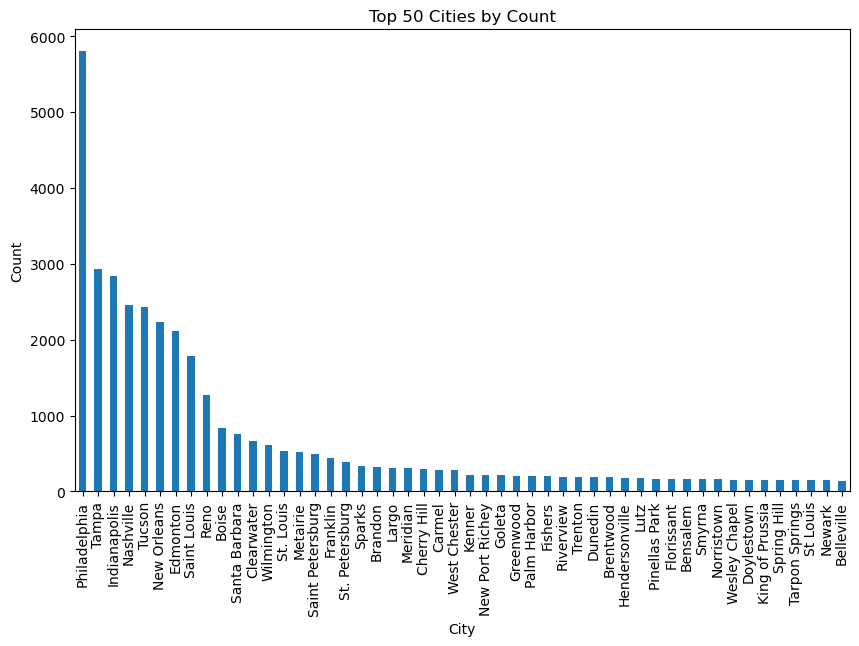

In [106]:
# Calculate the frequency of each city
city_counts = df_b['city'].value_counts()

# Select the top 200 cities
top_50_cities = city_counts.head(50)

# Plot a bar chart of the top 50 cities
top_50_cities.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Count')
plt.xlabel('City')
plt.title('Top 50 Cities by Count')
plt.show()

In [107]:
# Step 1: Get city counts before one-hot encoding
city_counts = df_b['city'].value_counts()
city_with_low_count = set(city_counts[city_counts < 200].index)


In [108]:
city_with_low_count

{'Abington',
 'Abington Township',
 'Affton',
 'Aldan',
 'Algiers',
 'Alloway',
 'Alton',
 'Ambler',
 'Antioch',
 'Apollo Beach',
 'Arabi',
 'Ardmore',
 'Arnold',
 'Ashland',
 'Ashland City',
 'Aston',
 'Atco',
 'Audubon',
 'Audubon ',
 'Avon',
 'Avondale',
 'BOISE',
 'BRANDON',
 'Bala Cynwyd',
 'Ballwin',
 'Balm',
 'Bargersville',
 'Barrington',
 'Bayonet Point',
 'Beaumont',
 'Beech Grove',
 'Bel Ridge',
 'Belle Chase',
 'Belle Chasse',
 'Belle Meade',
 'Belleair Blf',
 'Belleair Bluffs',
 'Bellefontaine',
 'Bellefontaine Neighbors',
 'Belleville',
 'Bellevue',
 'Bellmawr',
 'Bellville',
 'Belmont Hills',
 'Bensalem',
 'Bensalem Township',
 'Bensalem. Pa',
 'Berkeley',
 'Berlin',
 'Berlin Township',
 'Berry Hill',
 'Berwyn',
 'Bethalto',
 'Bethel',
 'Bethel Township',
 'Beverly',
 'Birchrunville',
 'Black Jack',
 'Blackwood',
 'Blackwood ',
 'Blooming Glen',
 'Blue Bell',
 'Blvd',
 'Boise City',
 'Boone',
 'Boothwyn',
 'Bordentown',
 'Boyertown',
 'Breckenridge Hills',
 'Brentwood',


In [109]:

# Step 2: One-hot encode the dataframe
df_b = pd.get_dummies(data=df_b, columns=['city'], prefix=None)

# Step 3: Determine columns (cities) to remove and remove them
columns_to_remove = {'city_' + col for col in city_with_low_count}.intersection(set(df_b.columns))
df_b.drop(columns_to_remove, axis=1, inplace=True)


In [110]:
df_b.head()

,stars,review_count,is_open,acai bowls,active life,african,arcades,asian fusion,automotive,bagels,bakeries,barbeque,beer bar,beer gardens,breakfast & brunch,bubble tea,buffets,burgers,cafes,cajun/creole,canadian (new),caribbean,cheesesteaks,chicken shop,chicken wings,chinese,cocktail bars,coffee & tea,coffee roasteries,comfort food,creperies,cuban,dance clubs,delis,desserts,dim sum,diners,dive bars,donuts,ethnic food,falafel,farmers market,fast food,filipino,fish & chips,food court,food delivery services,food stands,food trucks,french,fruits & veggies,gastropubs,german,gluten-free,greek,grocery,halal,health markets,hookah bars,hot dogs,hotels,ice cream & frozen yogurt,imported food,indian,irish,irish pub,italian,jazz & blues,juice bars & smoothies,karaoke,korean,latin american,local flavor,lounges,meat shops,mediterranean,middle eastern,modern european,new mexican cuisine,noodles,pakistani,party & event planning,pasta shops,pizza,pubs,ramen,salad,sandwiches,seafood,seafood markets,shopping,soul food,soup,southern,spanish,sports bars,steakhouses,street vendors,szechuan,tapas bars,tapas/small plates,tea rooms,tex-mex,thai,vegan,vegetarian,venues & event spaces,vietnamese,waffles,wine bars,wraps,American_cuisine,Bars_nightlife,Beer_wine_spirits,Caterers_event_planning,Specialty_food,Japanese,BrewPub,Hawaiian_poke,Mexican_tacos,WiFi,OutdoorSeating,GoodForKids,RestaurantsDelivery,RestaurantsReservations,Caters,RestaurantsGoodForGroups,RestaurantsTakeOut,Alcohol,RestaurantsAttire,HappyHour,WheelchairAccessible,BikeParking,ParkingAvailability,romantic,trendy,casual,touristy,hipster,classy,intimate,divey,upscale,Noise_Avg,Noise_Loud,Noise_Quiet,PriceRange_2,PriceRange_3,PriceRange_4,PriceRange_None,city_Boise,city_Brandon,city_Carmel,city_Cherry Hill,city_Clearwater,city_Edmonton,city_Fishers,city_Franklin,city_Goleta,city_Greenwood,city_Indianapolis,city_Kenner,city_Largo,city_Meridian,city_Metairie,city_Nashville,city_New Orleans,city_New Port Richey,city_Palm Harbor,city_Philadelphia,city_Reno,city_Saint Louis,city_Saint Petersburg,city_Santa Barbara,city_Sparks,city_St. Louis,city_St. Petersburg,city_Tampa,city_Tucson,city_West Chester,city_Wilmington
0,4.0,80,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0.0,0,1,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2.0,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,0.0,1,0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3.0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,1,0,0.0,0,0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.5,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0.0,1,0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.0,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,False,0,0,0,

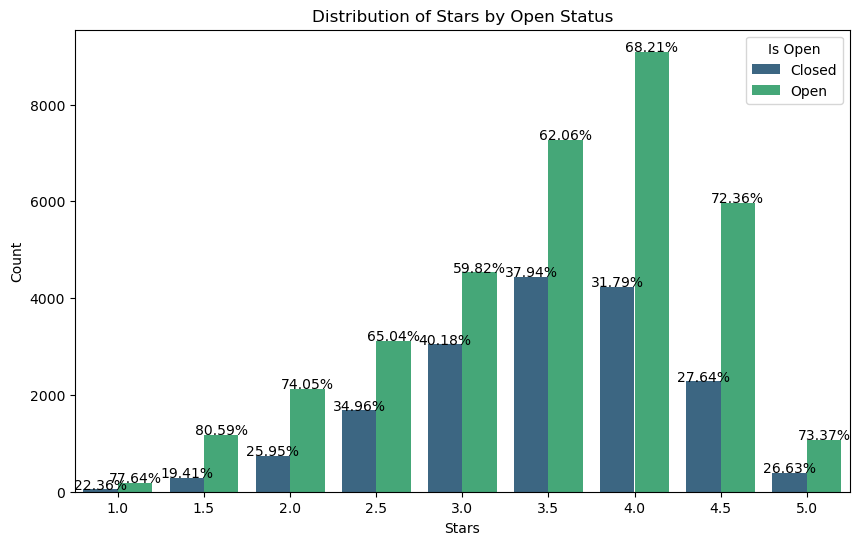

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the grouped bar chart
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='stars', hue='is_open', data=df_b, palette='viridis')

# Add title and labels
plt.title('Distribution of Stars by Open Status')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.legend(title='Is Open', loc='upper right', labels=['Closed', 'Open'])

# Compute the number of closed and open restaurants for each star rating
closed_counts = df_b[df_b['is_open'] == 0]['stars'].value_counts()
open_counts = df_b[df_b['is_open'] == 1]['stars'].value_counts()

# Compute the total count for each star rating
total_counts = df_b['stars'].value_counts()

# Compute the percentage of closed and open restaurants for each star rating
closed_percentages = (closed_counts / total_counts) * 100
open_percentages = (open_counts / total_counts) * 100

# Annotate the bar plot with the percentages
for index, p in enumerate(ax.patches):
    # If index is less than the number of star categories, it's a 'Closed' bar
    if index < len(closed_percentages):
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.,
                height + 5,
                '{:1.2f}%'.format(closed_percentages[sorted(closed_percentages.index)[index]]),
                ha="center")
    # Otherwise, it's an 'Open' bar
    else:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.,
                height + 5,
                '{:1.2f}%'.format(open_percentages[sorted(open_percentages.index)[index - len(closed_percentages)]]),
                ha="center")

# Display the plot
plt.show()


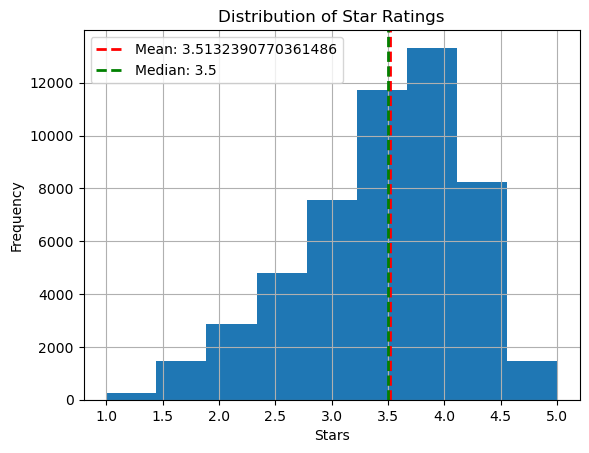

In [112]:
import matplotlib.pyplot as plt

mean_stars = df_b['stars'].mean()
median_stars = df_b['stars'].median()

df_b['stars'].hist(bins=9) 
plt.axvline(mean_stars, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_stars}')
plt.axvline(median_stars, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_stars}')
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.title('Distribution of Star Ratings')
plt.legend()
plt.show()


In [113]:
print(df_b['stars'].shape)
print(df_b['stars'].head())


(51703,)
0    4.0
1    2.0
2    3.0
3    1.5
4    4.0
Name: stars, dtype: float64


The mean (3.57) and median (3.5) are relatively close to each other, which suggests that the distribution may not be heavily skewed.

 Now we want transform the "stars" column into a binary variable

In [114]:
df_b['Rating_Success'] = (df_b['stars'] >= 4).astype(int)


In [115]:
df_b = df_b.drop(columns=['stars'])


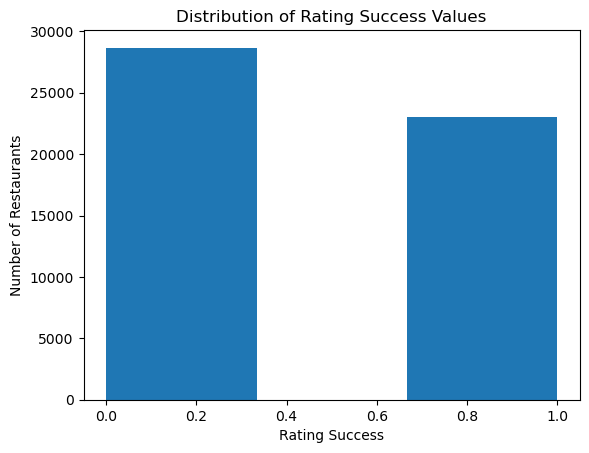

In [116]:
plt.figure()
plt.hist(df_b['Rating_Success'], bins=3)
plt.title("Distribution of Rating Success Values")
plt.xlabel("Rating Success")
plt.ylabel("Number of Restaurants")
plt.show()


In [117]:
binary_columns = [ 'WiFi', 'OutdoorSeating', 'GoodForKids', 'RestaurantsDelivery',
    'RestaurantsReservations', 'Caters', 'RestaurantsGoodForGroups',
    'RestaurantsTakeOut', 'Alcohol', 'RestaurantsAttire', 'WheelchairAccessible',
    'BikeParking'] 

In [118]:
binary_columns = [ 'WiFi', 'OutdoorSeating', 'GoodForKids', 'RestaurantsDelivery',
    'RestaurantsReservations', 'Caters', 'RestaurantsGoodForGroups',
    'RestaurantsTakeOut', 'Alcohol', 'RestaurantsAttire', 'WheelchairAccessible',
    'BikeParking']  # Include only truly binary columns here
df_b[binary_columns] = df_b[binary_columns].astype('uint8')


In [119]:
correlation = df_b.corrwith(df_b['Rating_Success'])
print(correlation)


review_count         0.158318
is_open              0.061054
acai bowls           0.039141
active life         -0.005319
african              0.017273
                       ...   
city_Tampa           0.027765
city_Tucson         -0.021665
city_West Chester    0.002252
city_Wilmington     -0.005999
Rating_Success       1.000000
Length: 181, dtype: float64


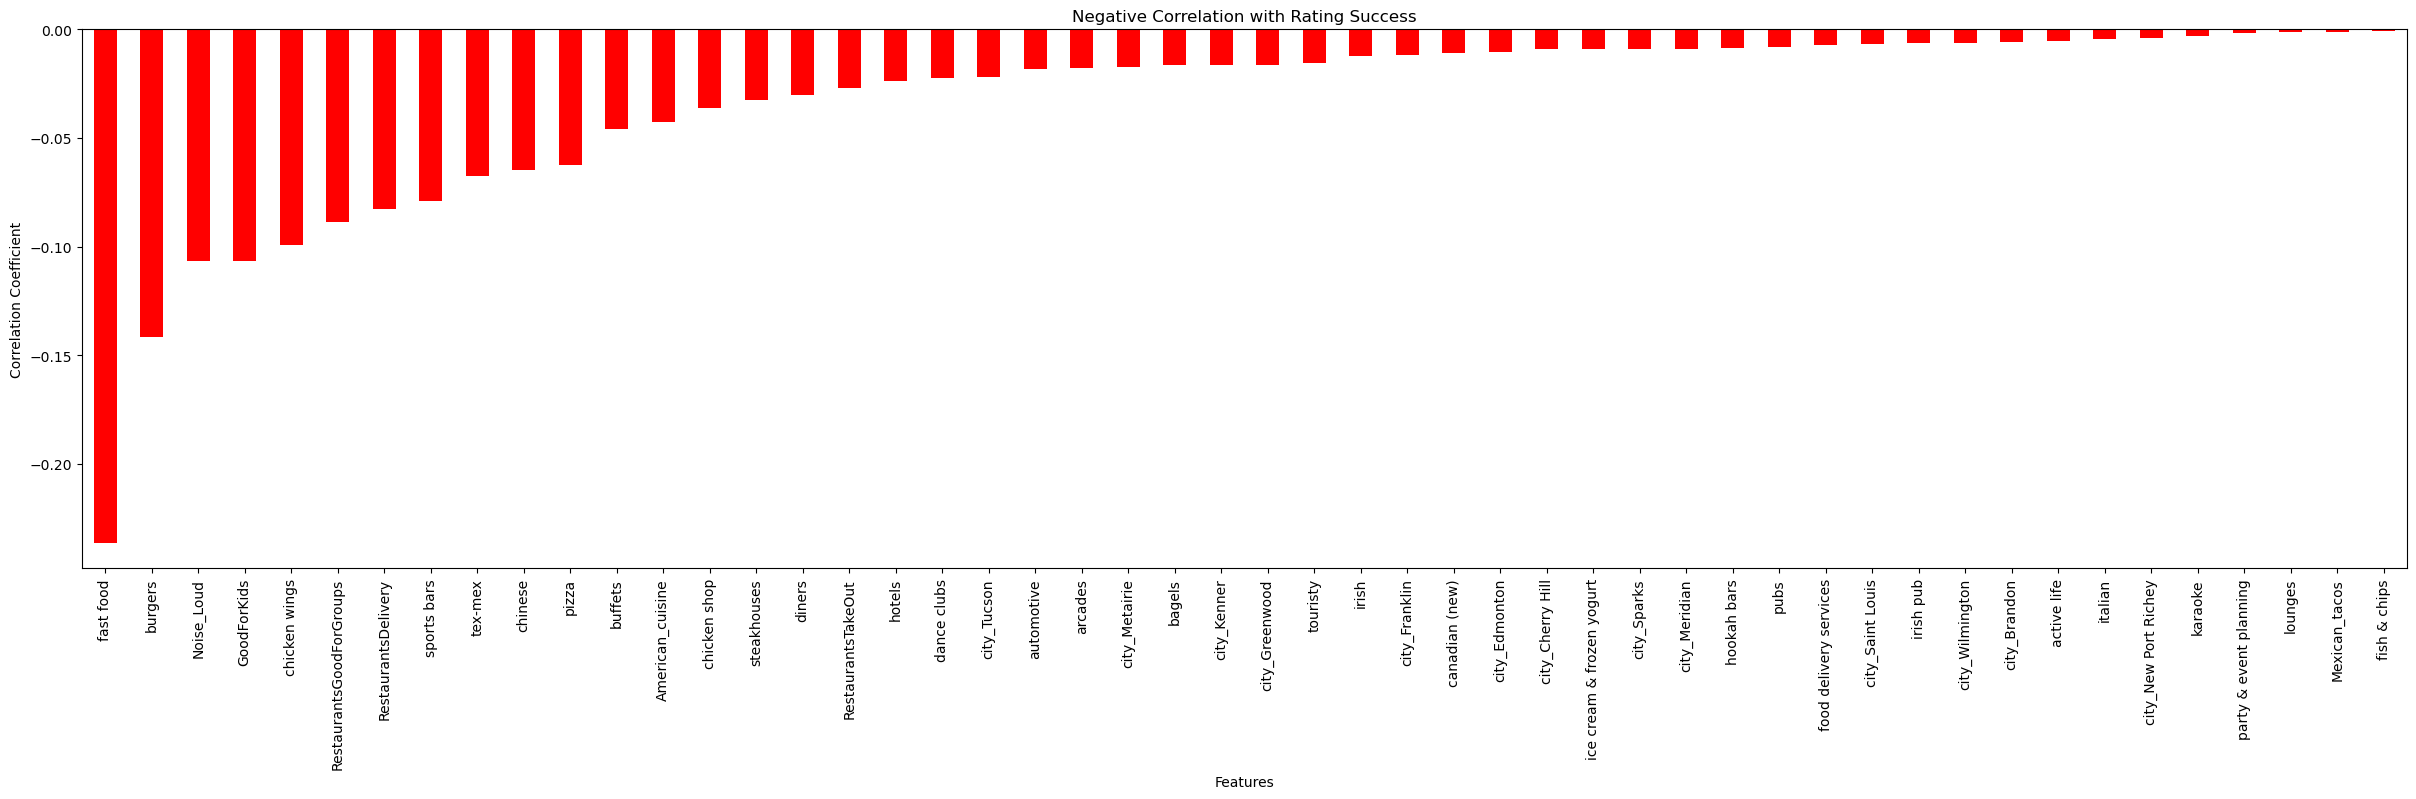

In [120]:
import matplotlib.pyplot as plt

# Calculate the correlation with the target variable
correlation = df_b.corrwith(df_b['Rating_Success'])

# Drop the target variable from the correlation results
correlation.drop('Rating_Success', inplace=True)

# Sort the correlation values
sorted_correlation = correlation.sort_values()

# Split into positive and negative correlations
negative_correlation = sorted_correlation[sorted_correlation < 0]
positive_correlation = sorted_correlation[sorted_correlation >= 0]

# Plot the negative correlations
plt.figure(figsize=(30, 7))
negative_correlation.plot(kind='bar', color='red')
plt.title('Negative Correlation with Rating Success')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.show()


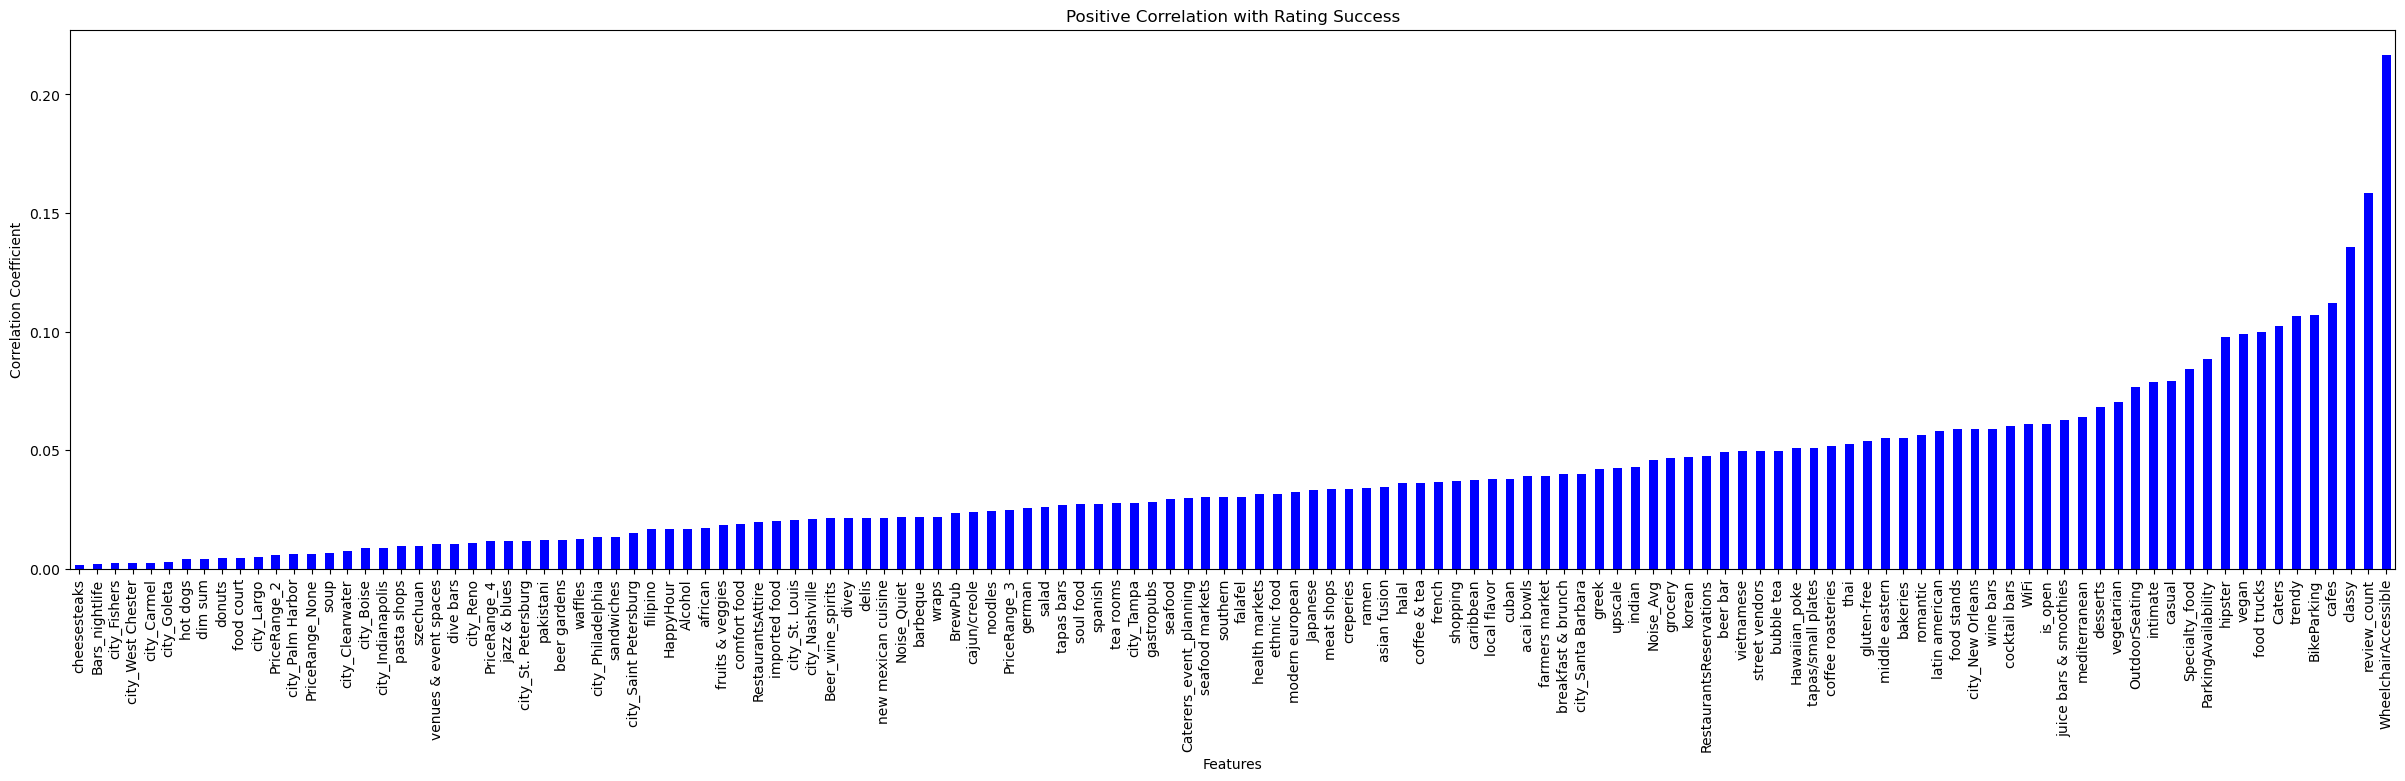

In [121]:

# Plot the positive correlations
plt.figure(figsize=(30, 7))
positive_correlation.plot(kind='bar', color='blue')
plt.title('Positive Correlation with Rating Success')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.show()


In [122]:

correlation_matrix = df_b.corr()

# Get pairs of variables with correlation > 0.50
highly_correlated_pairs = []

for i, row in enumerate(correlation_matrix.index):
    for j, col in enumerate(correlation_matrix.columns):
        # Check for correlation above 0.50 and ensure we're not looking at the diagonal
        if correlation_matrix.iloc[i, j] > 0.50 and i != j:
            # Since the matrix is symmetric, let's only store one of (i,j) or (j,i)
            if (col, row) not in highly_correlated_pairs:
                highly_correlated_pairs.append((row, col))

# Print the results
for pair in highly_correlated_pairs:
    print(f"Variables {pair[0]} and {pair[1]} have a correlation > 0.50")
    



Variables ethnic food and Specialty_food have a correlation > 0.50


In [123]:
df_b['Specialty_food'] = df_b['Specialty_food'] | df_b['ethnic food']
df_b['Indian'] = df_b['indian'] | df_b['pakistani']
df_b['Caterers_event_planning'] = df_b['venues & event spaces'] | df_b['Caterers_event_planning']

df_b.reset_index(drop=True, inplace=True)

In [124]:
df_b.drop(columns=['Specialty_food','ethnic food','pakistani',
                   'indian','venues & event spaces','Caterers_event_planning','city_Edmonton'],inplace=True)
df_b.reset_index(drop=True, inplace=True)

In [132]:
# import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming 'Rating_Success' is your target variable
X = df_b.drop(columns=['Rating_Success'])
y = df_b['Rating_Success']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creating and fitting the logistic regression model with L1 penalty
log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear')
log_reg_l1.fit(X_train_scaled, y_train)



# Evaluating the model on the train data
train_score = log_reg_l1.score(X_train, y_train)
print(f'Train Accuracy: {train_score}')
# Evaluating the model on the test data
test_score = log_reg_l1.score(X_test, y_test)
print(f'Test Accuracy: {test_score}','\n')


# Evaluating the model on the scaled train data
train_score = log_reg_l1.score(X_train_scaled, y_train)
print(f'Scaled Train Accuracy: {train_score}')

# Evaluating the model on the scaled test data
test_score = log_reg_l1.score(X_test_scaled, y_test)
print(f'Scaled Test Accuracy: {test_score}')






Train Accuracy: 0.4460101679929266
Test Accuracy: 0.44445877119463606 

Scaled Train Accuracy: 0.7193578691423519
Scaled Test Accuracy: 0.7059506156920895


/Users/hodaya/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/hodaya/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


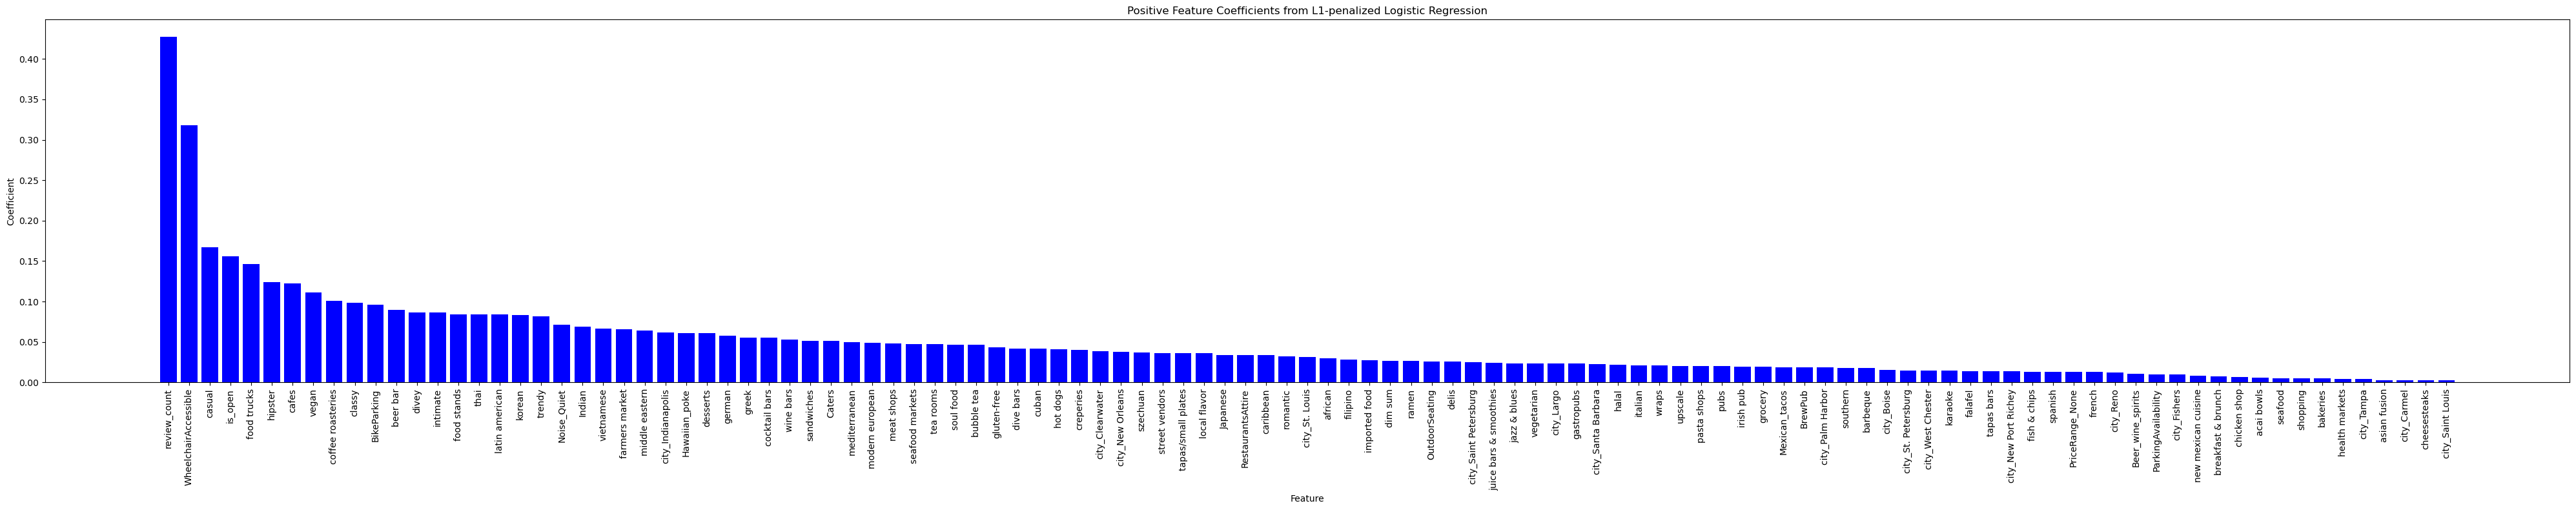

In [126]:

# Get feature names
features = X.columns

# Get coefficients and feature names
coefs = log_reg_l1.coef_[0]

# Create indices for sorting based on coefficients
sorted_idx = np.argsort(coefs)

# Separate and sort positive and negative coefficients
sorted_negative_coefs = coefs[sorted_idx][coefs[sorted_idx] < 0]
sorted_positive_coefs = coefs[sorted_idx][coefs[sorted_idx] > 0][::-1]

# Sort feature names based on the same order
sorted_features_neg = np.array(features)[sorted_idx][coefs[sorted_idx] < 0]
sorted_features_pos = np.array(features)[sorted_idx][coefs[sorted_idx] > 0][::-1]

# Plot positive coefficients
plt.figure(figsize=(40, 8))
plt.bar(sorted_features_pos, sorted_positive_coefs, color='blue')
plt.title("Positive Feature Coefficients from L1-penalized Logistic Regression")
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


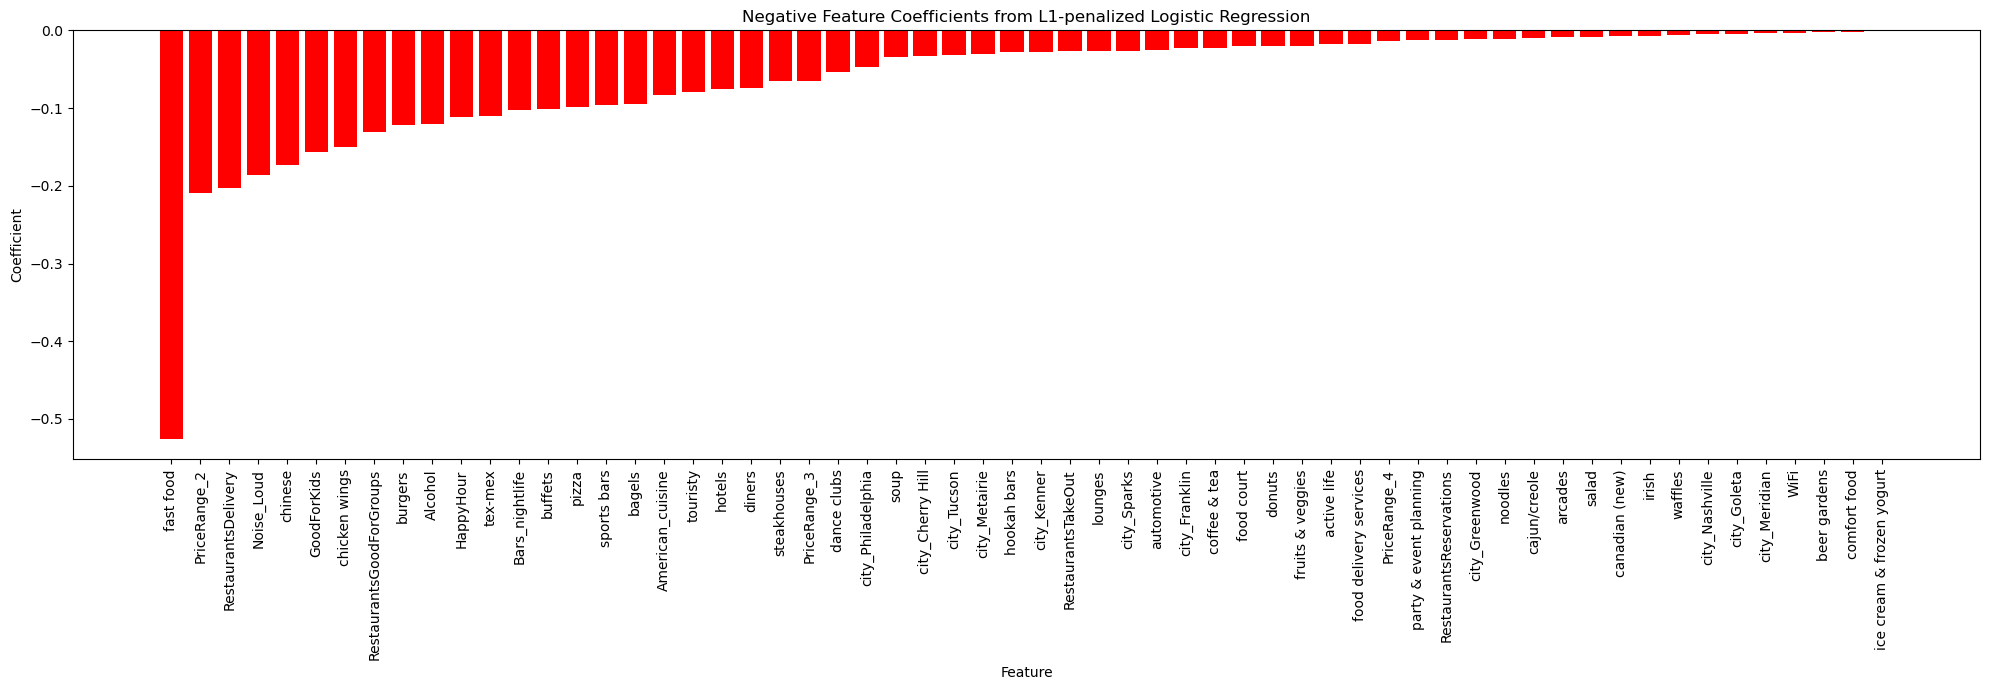

In [131]:
# Plot negative coefficients
plt.figure(figsize=(20, 7))
plt.bar(sorted_features_neg, sorted_negative_coefs, color='red')
plt.title("Negative Feature Coefficients from L1-penalized Logistic Regression")
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [154]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# ... [the previous code you provided to split and scale the data is still valid]

# Create and fit the decision tree model
clf = DecisionTreeClassifier(max_depth=8)  # limiting depth for visualization purposes
clf.fit(X_train_scaled, y_train)

# Evaluating the model on the unscaled train data
train_score = clf.score(X_train, y_train)
print(f'DecisionTree Train Accuracy: {train_score}')

# Evaluating the model on the unscaled test data
test_score = clf.score(X_test, y_test)
print(f'DecisionTree Test Accuracy: {test_score}','\n')

# Evaluating the model on the scaled train data
scaled_train_score = clf.score(X_train_scaled, y_train)
print(f'DecisionTree Scaled Train Accuracy: {scaled_train_score}')

# Evaluating the model on the scaled test data
scaled_test_score = clf.score(X_test_scaled, y_test)
print(f'DecisionTree Scaled Test Accuracy: {scaled_test_score}')


DecisionTree Train Accuracy: 0.4460101679929266
DecisionTree Test Accuracy: 0.44445877119463606 

DecisionTree Scaled Train Accuracy: 0.6930813439434129
DecisionTree Scaled Test Accuracy: 0.671974727612662


/Users/hodaya/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/hodaya/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


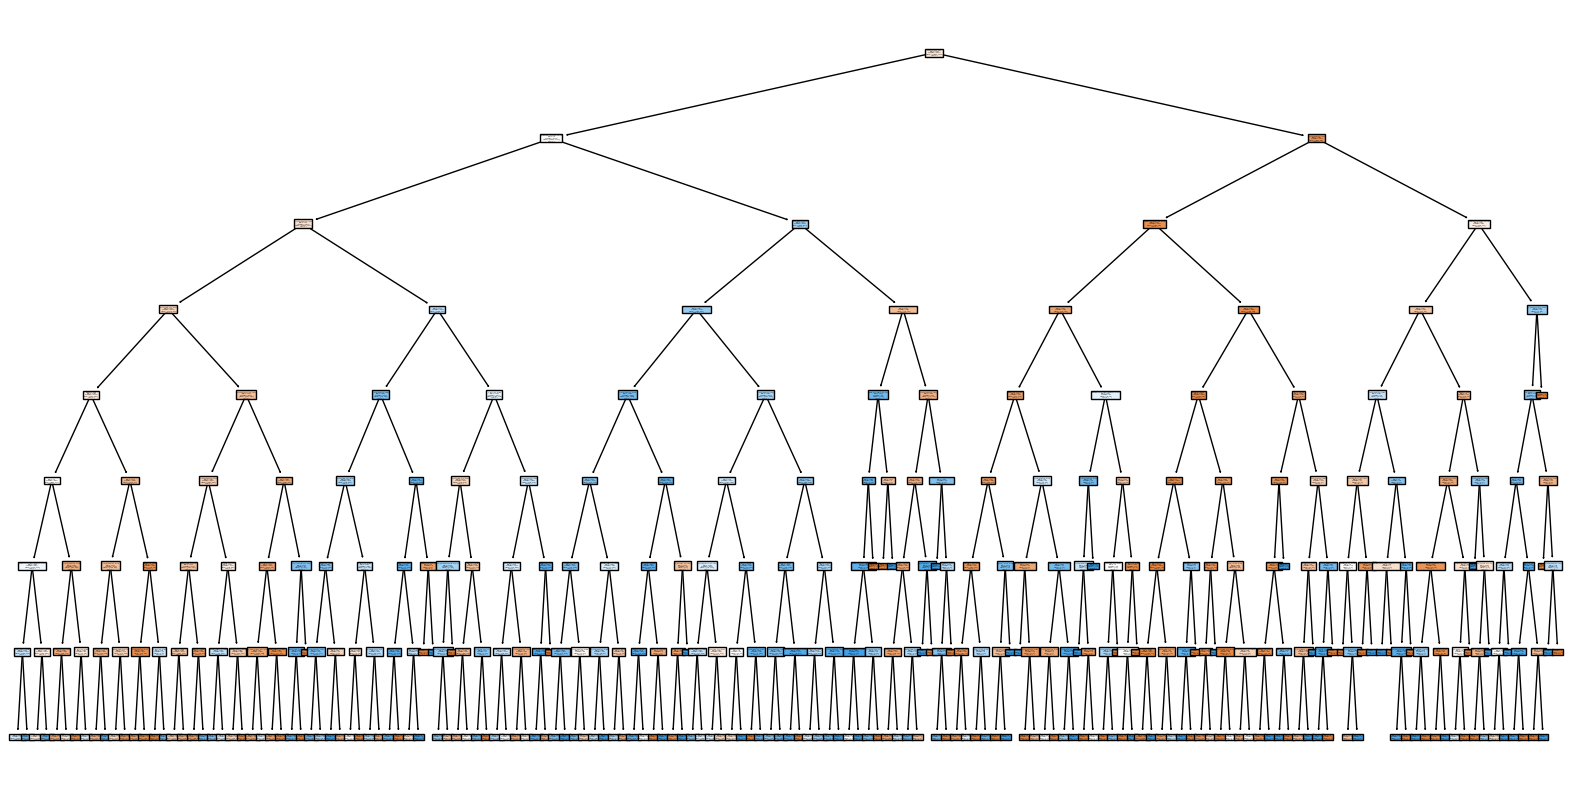

In [155]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X.columns.tolist(), class_names=[str(cls) for cls in clf.classes_])
plt.show()

In [128]:
df_b.shape

(51703, 175)